### Procedure for Evaluation : Cyrillic Labels - Smriti

* Open taxon, collector, geography gt-labels and the gpt-resized-results 
* Check if gpt-file has attribute of scientificname, collected by / recorded by, country/locality
* Make count of all comparable files (some don't have valid responses - ignore these)
* Check match of the gt with produced labels (if produced label in gt) or perhaps some better match method (similarity measures)
* Count number of matches with some threshold value ->50% match 
* Measure of accuracy 

In [60]:
#installations necessary
# pip install taxonerd
# pip install https://github.com/nleguillarme/taxonerd/releases/download/v1.5.0/en_core_eco_biobert-1.0.2.tar.gz
# pip install tqdm
# pip install seaborn

In [61]:
#import statements
import os
import pandas as pd
import numpy as np
import re
from taxonerd import TaxoNERD
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

### Convert ground truth labels into Dataframe for easy access

In [65]:
print(os.getcwd())
# os.chdir("gt_labels/")
# os.chdir("../ml-herbarium-data/scraped-data/drago_testdata/gt_labels")
os.chdir('../CyrillicImages/')
gt = pd.read_csv('CyrillicData-new.csv')

/projectnb/sparkgrp/ml-herbarium-grp/fall2023/CyrillicResults


In [66]:
gt.head()

,image number,Handwritten,Barcode,scientificName,country,recordedBy,eventDate,Label text (georgraphy and ecology),Unnamed: 8
0,1,No,MW0464618,Ledum palustre L.,Russia,Вехов В.Н.,1983-07-06,"Карелия, Ругозерская губа Кандалакшского залив...",NaN
1,2,Yes,MW0001412,Pinus funebris Kom.,Russia,В. Комаров,1930-09-07,"г. Никольск-Уссурийский, долина р. Супутинки. ...",NaN
2,3,Yes,MW0001364,Pinus pumila Rgl.\r,Russia,В. Куваев,1951-07-15,"о. 6. Томп. Верх. хр. горы, лиственничная тайг...",NaN
3,4,Yes,MW0001309,Pinus pumila (Pall.) Regl.\r,Russia,\tКарев Г.И.,1930-0626,Камчатка. Козыревский совхоз = урочище Среднек...,NaN
4,5,Yes,MW0001310,Pinus pumila Rgl.,Russia,В. Комаров,1909-10-10,Камчатка. У Петропавловска на Петровской горе,NaN


In [67]:
gt = gt.drop("Unnamed: 8", axis=1)

In [68]:
gt = gt.rename(columns = {'image number': 'ID', 'scientificName':'Taxon', 'recordedBy':'Collector','country ':'Geography'})

#### Convert all labels to lower case and remove escape characters

In [69]:
gt['Taxon'] = gt['Taxon'].str.lower().replace("\t\n", "")
gt['Collector'] = gt['Collector'].str.lower().replace("\t\n", "")
gt['Geography'] = gt['Geography'].str.lower().replace("\t\n", "")
gt = gt.fillna('')

In [70]:
gt.head()

,ID,Handwritten,Barcode,Taxon,Geography,Collector,eventDate,Label text (georgraphy and ecology)
0,1,No,MW0464618,ledum palustre l.,russia,вехов в.н.,1983-07-06,"Карелия, Ругозерская губа Кандалакшского залив..."
1,2,Yes,MW0001412,pinus funebris kom.,russia,в. комаров,1930-09-07,"г. Никольск-Уссурийский, долина р. Супутинки. ..."
2,3,Yes,MW0001364,pinus pumila rgl.\r,russia,в. куваев,1951-07-15,"о. 6. Томп. Верх. хр. горы, лиственничная тайг..."
3,4,Yes,MW0001309,pinus pumila (pall.) regl.\r,russia,\tкарев г.и.,1930-0626,Камчатка. Козыревский совхоз = урочище Среднек...
4,5,Yes,MW0001310,pinus pumila rgl.,russia,в. комаров,1909-10-10,Камчатка. У Петропавловска на Петровской горе


### Extract results from Azure model into pandas dataframe

In [71]:
#Load the azure vision results
os.chdir('../CyrillicResults/')
print(os.getcwd())
# os.chdir('/projectnb/sparkgrp/ml-herbarium-grp/fall2023/temp/')

folder_path = os.getcwd()
result_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith(('txt'))]

#checking for duplicate files
print(len(result_files)==len(set(result_files)))
rows = []
for i in result_files:
    # print(i)
    # break
    f = open(i, 'r')
    lines = f.readlines()
    new_row=[]
    taxon_res=""
    geo_res=""
    col_res=""
    
    for line in lines:
        if "scientificname\":" in line.lower():
            taxon_res=line.strip().split(":")[1].replace(",","").replace('"', '').lstrip()
        if "country\":" in line.lower():
            geo_res=line.strip().split(":")[1].replace(",","").replace('"', '').lstrip()
        if "collectedby\":" in line.lower() or "recordedby\":" in line.lower() or "collector\":" in line.lower():
            # print(line.strip().split(":"))
            col_res=line.strip().split(":")[1].replace(",","").replace('"', '').lstrip()
            
    new_row = [i.replace('.txt',''),taxon_res,col_res,geo_res]
    rows.append(new_row)
    f.close()


/projectnb/sparkgrp/ml-herbarium-grp/fall2023/CyrillicResults
True


In [72]:
rt = pd.DataFrame(rows, columns=['ID', 'rTaxon', 'rCollector', 'rGeography'])

In [73]:
rt = rt.fillna("")

In [74]:
rt.isnull().values.any()

False

In [75]:
np.where(pd.isnull(rt))

(array([], dtype=int64), array([], dtype=int64))

In [76]:
np.where(rt.map(lambda x: x == ''))

(array([ 0,  1,  6, 11, 14, 15, 15, 17, 18, 19, 20, 25, 27, 28, 29, 32, 33]),
 array([2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 1, 2, 1]))

### Noting down empty values

In [77]:
rt[rt['rTaxon'] == '']['ID']

1     21
6     12
11    20
14    14
15     3
17    18
18    11
25     8
27     7
29    13
33    10
Name: ID, dtype: object

In [78]:
rt[rt['rCollector'] == '']['ID']

0     28
15     3
19     2
28    30
32    17
Name: ID, dtype: object

In [79]:
rt[rt['rGeography'] == '']['ID']

20    29
Name: ID, dtype: object

In [80]:
rt.head()

,ID,rTaxon,rCollector,rGeography
0,28,Pinus sibirica (Rupr.) Mayr.,,Russia
1,21,,С. Туманян,Kyrgyzstan
2,32,Pinus sylvestris L.,Н. Шведчикова,Russia
3,15,Rostraria cristata (L.) Tzvelev,A. Seregin,Greece
4,25,Pinus pumila (Pall) Regel,G. I. Karev,Russia


## Comparison with Ground Truth Labels

### Creating a combined Dataframe for easy comparison between columns

In [81]:
rt['ID'] = rt['ID'].astype(str).astype(int)

In [82]:
new_df = (pd.merge(gt, rt[['ID','rTaxon','rCollector','rGeography']], on='ID'))

In [83]:
new_df.head()

,ID,Handwritten,Barcode,Taxon,Geography,Collector,eventDate,Label text (georgraphy and ecology),rTaxon,rCollector,rGeography
0,1,No,MW0464618,ledum palustre l.,russia,вехов в.н.,1983-07-06,"Карелия, Ругозерская губа Кандалакшского залив...",Ledum palustre L.,Вехов В.Н.,Russia
1,2,Yes,MW0001412,pinus funebris kom.,russia,в. комаров,1930-09-07,"г. Никольск-Уссурийский, долина р. Супутинки. ...",Pinus fundbais uma,,Russia
2,3,Yes,MW0001364,pinus pumila rgl.\r,russia,в. куваев,1951-07-15,"о. 6. Томп. Верх. хр. горы, лиственничная тайг...",,,Russia
3,4,Yes,MW0001309,pinus pumila (pall.) regl.\r,russia,\tкарев г.и.,1930-0626,Камчатка. Козыревский совхоз = урочище Среднек...,Pinus pumila (Pallas) Regel,Г. И. Карев,Russia
4,5,Yes,MW0001310,pinus pumila rgl.,russia,в. комаров,1909-10-10,Камчатка. У Петропавловска на Петровской горе,Pinus pumila,V. Komarov,Russia


In [84]:
np.where(pd.isnull(new_df))

(array([], dtype=int64), array([], dtype=int64))

In [85]:
np.where(new_df.map(lambda x: x == ''))

(array([ 1,  2,  2,  6,  6,  7,  9,  9, 10, 11, 12, 12, 13, 13, 16, 16, 17,
        17, 19, 20, 27, 28, 29]),
 array([ 9,  8,  9,  3,  8,  8,  3,  8,  8,  8,  3,  8,  3,  8,  6,  9,  3,
         8,  8,  8,  9, 10,  9]))

#### Observed variations in the word USA - so converting all variations to the standard of Ground Truth label

In [86]:
##Replacing all USA variations with one label

# for i in new_df['rGeography']:
#     if i=="USA" in i or "United States" in i:

new_df['rGeography'] = new_df['rGeography'].apply(lambda i: "united states of america" if i.lower() in ["usa","united states","us"] else i)

In [87]:
p = re.compile(r'[^\s\w]+')

for i in new_df[['Taxon']]:
    if i=="ID":
        continue
    new_df[i] = new_df[i].str.lower()
    # print(new_df[i].tolist())
    # new_df[i] = [p.sub('', x) for x in new_df[i].tolist()]
    # print(new_df[i])

Note : We were unable to complete removal of punctuation from the samples since the regex library had difficulty processing Cyrillic characters - we will explore more ways to preprocess Cyrillic data

## Taxon Metrics

### 1. Accuracy

In [88]:
#Taxon accuracy - count as 1 only if ground truth label is present as is in extracted label
c=0
for index, row in new_df.iterrows():
    # print(row)
    if pd.isna(row['Taxon']):
        continue
    if row['Taxon'].lower() in row['rTaxon'].lower():
        c+=1

In [89]:
print(c)

15


In [90]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 42.857142857142854%


In [91]:
# Approach 2 : count as 1 if any word in ground truth label is present in extracted label

c=0
for index, row in new_df.iterrows():
    if pd.isna(row['Taxon']):
        continue
    if any(x in row['rTaxon'].lower() for x in row['Taxon'].lower().split()):
        c+=1

In [92]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 57.14285714285714%


In [93]:
# Approach 3 : count as 1 if all words in ground truth label is present in extracted label (need not be in order)

c=0
for index, row in new_df.iterrows():
    if pd.isna(row['Taxon']):
        continue
    if(set(row['Taxon'].lower().split()).issubset(set(row['rTaxon'].lower().split()))):
        c+=1

In [94]:
print(c)

15


In [95]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 42.857142857142854%


## 2. Extended Approach : Utilizing TaxoNERD and Cosine Similarity for predicting closest taxons

In [96]:
! nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Sat Dec  9 23:21:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V

In [97]:
taxonerd = TaxoNERD(prefer_gpu=False) # set to "true" if GPU is accessible

In [98]:
# utility functions for finding cosine similarity

def word2vec(word):
    from collections import Counter
    from math import sqrt
    
    # count the characters in word
    # print(word)
    cw = Counter(word)
    # precomputes a set of the different characters
    sw = set(cw)
    # precomputes the "length" of the word vector
    lw = sqrt(sum(c*c for c in cw.values()))

    # return a tuple
    return cw, sw, lw

def cosdis(v1, v2):
    # which characters are common to the two words?
    common = v1[1].intersection(v2[1])
    # by definition of cosine distance we have
    return sum(v1[0][ch]*v2[0][ch] for ch in common)/v1[2]/v2[2]

In [99]:
taxon_output = []
confidence_output = []

nlp = taxonerd.load(
    model="en_core_eco_biobert", 
    linker="gbif_backbone", 
    threshold=0
)

In [100]:
# predict taxons for text detected from each image
for index, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
    temp = row["rTaxon"]

    # construct a single string out of all the detected text
    input_text = temp
    doc = taxonerd.find_in_text(input_text)

    try:
        # append linked taxon entity and confidence
        taxon_output.append(str(doc.entity[0][0][1]))
        confidence_output.append(float(doc.entity[0][0][2]))

    except AttributeError:
        # append empty strings when no entity is detected
        taxon_output.append("")
        confidence_output.append(float(0))

100%|██████████| 35/35 [00:24<00:00,  1.41it/s]


In [101]:
# append predicted taxon and confidence scores to the dataframe
new_df["Taxon_pred_Output"] = taxon_output
new_df["Taxon_Confidence_Output"] = confidence_output

In [102]:
# array to store computed similarity scores
cosine_sim = []

for index, row in new_df.iterrows():

    # extract image name from the dataframe
    # img_name = row["ID"]
    # if pd.isna(row['Taxon']):
    #     continue
    taxon_predicted = row["Taxon_pred_Output"]
    taxon_gt = row["Taxon"]

    # compute cosine similarity between the predicted taxon and ground truth
    try:
        sim = cosdis(word2vec(taxon_gt), word2vec(taxon_predicted))
        cosine_sim.append(sim)
        # print(taxon_gt, taxon_predicted, sim)

    except ZeroDivisionError:
        cosine_sim.append(0)
        # print(taxon_gt, taxon_predicted,"0")

# append similarity scores to the dataframe
new_df["Cosine_Similarity"] = cosine_sim

In [103]:
final_taxon_prediction = pd.DataFrame(columns=["Confidence_Threshold", "Taxons_Predicted", "Taxons_Accuracy_Predicted"])
temp_df = pd.DataFrame()

# generate list of similarity thresholds
# sim_threshold = [0.9]
sim_threshold =0.8

# generate list of confidence thresholds
confidence_threshold = np.arange(0, 1, 0.1)

# compute prediction accuracy at each confidence threshold
for conf_threshold in confidence_threshold:
    
    temp_df = new_df[(new_df["Taxon_Confidence_Output"] > conf_threshold)]
    
    acc_count = (temp_df["Cosine_Similarity"] > sim_threshold).sum()

    acc_val = acc_count/len(temp_df)

    temp = [conf_threshold, acc_count, acc_val]
    final_taxon_prediction.loc[len(final_taxon_prediction)] = temp

display(final_taxon_prediction)

,Confidence_Threshold,Taxons_Predicted,Taxons_Accuracy_Predicted
0,0.0,13.0,0.590909
1,0.1,13.0,0.590909
2,0.2,13.0,0.590909
3,0.3,13.0,0.590909
4,0.4,13.0,0.590909
5,0.5,13.0,0.619048
6,0.6,13.0,0.619048
7,0.7,12.0,0.666667
8,0.8,12.0,0.750000
9,0.9,11.0,0.733333


Note : Adapted from Spring semester trocr-test notebook

1. We first obtain the taxon predictions with a confidence score for each taxon.
2. We then compute cosine similarities of the predicted taxons with the ground truth taxons.
3. We then, at each interval of the confidence threashold, compute number of taxons that have a high cosine similarity with the ground truth. The scores above are computed for a specific cosine similarity score ">0.8". We need to perform this step because, the taxons are matched against entries from the ncbi_taxonomy database (as part of TaxoNERD) and, the predicted taxon might not exactly match the ground truth and we are accounting for this using cosine similarity.
4. We can try to use the GBIF database to predict taxons and also experiment with different thresholds for the cosine similarity scores. But, in general, the chosen cosine similarity threshold offers an incremental performance upgrade compared to the last semester's work
5. Our highest Accuracy = 78.9% compared to Spring semester = 71.7% 

## Collector Metrics

### 1. Accuracy

In [104]:
#Approach 1 - count as 1 only if ground truth label is present as is in extracted label
c=0
for index, row in new_df.iterrows():
    if row['Collector'].lower() in row['rCollector'].lower():
        c+=1

In [105]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 8.571428571428571%


In [106]:
# Approach 2 : count as 1 if any word in ground truth label is present in extracted label

c=0
for index, row in new_df.iterrows():
    if any(x in row['rCollector'].lower() for x in row['Collector'].lower().split()):
        # print(row['Collector'].lower(), row['rCollector'].lower())
        c+=1

In [107]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 51.42857142857142%


In [108]:
# Approach 3 : count as 1 if all words in ground truth label is present in extracted label (need not be in order)

c=0
for index, row in new_df.iterrows():
    if(set(row['Collector'].lower().split()).issubset(set(row['rCollector'].lower().split()))):
        c+=1

In [109]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 14.285714285714285%


## Geography Metrics

### 1. Accuracy

In [110]:
#Approach 1 - count as 1 only if ground truth label is present as is in extracted label
c=0
for index, row in new_df.iterrows():
    
    if row['Geography'].lower() in row['rGeography'].lower():
        # print(row['Geography'].lower(), row['rGeography'].lower())
        c+=1

In [111]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 97.14285714285714%


In [112]:
# Approach 2 : count as 1 if any word in ground truth label is present in extracted label

c=0
for index, row in new_df.iterrows():
    if any(x in row['rGeography'].lower() for x in row['Geography'].lower().split()):
        # print(row['Geography'], row['rGeography'])
        c+=1

In [113]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 97.14285714285714%


In [114]:
# Approach 3 : count as 1 if all words in ground truth label is present in extracted label (need not be in order)

c=0
for index, row in new_df.iterrows():
    if(set(row['Geography'].lower().split()).issubset(set(row['rGeography'].lower().split()))):
        c+=1

In [115]:
acc = c/len(new_df)*100
print(f"Accuracy obtained : {acc}%")

Accuracy obtained : 97.14285714285714%


## Visualizations

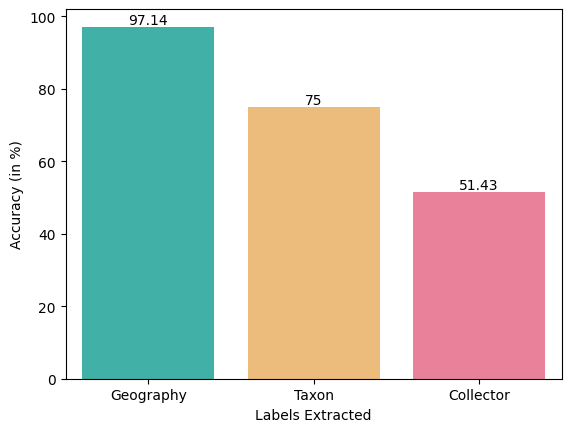

In [116]:
df_scores = pd.DataFrame({
        'Labels Extracted': ['Geography', 'Taxon', 'Collector'],
        'Accuracy (in %)': [97.14, 75.00, 51.43]
})

df_scores = df_scores.sort_values(['Accuracy (in %)'], ascending=False).reset_index(drop=True)
# who v/s fare barplot 
palette=["#2ec4b6","#ffbf69","#fb6f92"]
ax = sns.barplot(x = 'Labels Extracted',
            y = 'Accuracy (in %)',
           data = df_scores,
           hue = 'Labels Extracted',
           palette=palette)

for i in ax.containers:
    ax.bar_label(i,)
# Show the plot
plt.show()

## Appendix

#### Old Approach (Using entire Text) Metrics

In [59]:
new_df['Text'] = [p.sub('', x).strip("\n").strip("\t").lstrip() for x in new_df['Text'].tolist()]

KeyError: 'Text'

In [ ]:
scores = []

for index, row in new_df.iterrows():
    c=0.0
    row1 = row['Text'].split(" ")
    # print(row1)
    for w in row1:
        # print(w)
        if str(w) in row['rTaxon'] or str(w) in row['rCollector'] or str(w) in row['rGeography'] :
            # print(w)
            c+=1.0
    scores.append(c/len(row1))        

In [ ]:
print(scores)

In [ ]:
len(scores)

In [ ]:
combined_score = sum(scores)/35

print(combined_score)

### Comparing entire Azure text result with ground truth labels

In [ ]:
#Load the azure vision results
os.chdir('../CyrillicResults/')
print(os.getcwd())
# os.chdir('/projectnb/sparkgrp/ml-herbarium-grp/fall2023/temp/')

folder_path = os.getcwd()
result_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith(('txt'))]

#checking for duplicate files
print(len(result_files)==len(set(result_files)))
rows = []
for i in result_files:
    # print(i)
    # break
    f = open(i, 'r')
    text = f.read().strip()
    new_row = [i.replace('.txt',''),text]
    rows.append(new_row)
    f.close()

In [ ]:
rrt = pd.DataFrame(rows, columns=['ID', 'Text'])

In [ ]:
import re
p = re.compile(r'[^\w\s]+')

for i in rt[['Text']]:
    rrt[i] = rrt[i].astype(str)
    rrt[i] = rrt[i].str.lower()
    rrt[i] = [p.sub('', x) for x in rrt[i].tolist()]

In [ ]:
rrt.head()

In [ ]:
rrt= rrt.fillna("")
rrt['Text'] = [p.sub('', x).strip("\n").strip("\t").lstrip() for x in rrt['Text'].tolist()]

In [ ]:
gt= gt.fillna("")
gt['Text'] = [p.sub('', x).strip("\n").strip("\t").lstrip() for x in gt['Text'].tolist()]
gt['Taxon'] = [p.sub('', x).strip("\n").strip("\t").lstrip() for x in gt['Taxon'].tolist()]

In [ ]:
gt['Combined'] = gt['Taxon'] + " " + gt['Text']

In [ ]:
gt['rText'] = rrt['Text']

In [ ]:
gt['rText'] = [p.sub('', x).replace("\n", "") for x in gt['rText'].tolist()]

In [ ]:
scores = []

for index, row in gt.iterrows():
    c=0.0
    row1 = row['Text'].split(" ")
    # print(row1)
    for w in row1:
        # print(w)
        if str(w) in row['rText']:
            # print(w)
            c+=1.0
    scores.append(c/len(row1))        

In [ ]:
print(scores)

In [ ]:
combined_score = sum(scores)/35

print(combined_score)